<p align="center">
  <span style="font-size:56px; font-weight:700;">Malaria Predictive Modelling</span>
</p>

![Weekly Malaria Trends](Images/Weekly_Malaria_Trends.PNG)

Source: Exploratory Data Analysis - Group 2

## 1.0 Business Understanding

### 1.1 Executive Summary


Kenya’s health system continues to carry a heavy burden of infectious diseases; malaria remains a leading public‑health challenge, with 10 counties accounting for ~95% of the national burden. Turkana is among the highest‑burden areas, and Turkana West (Kakuma Refugee Camp) alone has managed >65,000 malaria cases annually over the past five years, with peaks occurring at different, increasingly unpredictable times of the year. Climate variability has disrupted the reliability of rainy seasons in arid and semi‑arid lands (ASAL), making reactive, delayed, and resource‑intensive responses the norm—resulting in lost livelihoods and schooling, stock‑outs, HCW burnout, and excess morbidity and mortality, especially among pregnant women and children.This capstone proposes a climate‑informed malaria early warning and response (EWR) platform that combines recent weather conditions (rainfall, temperature, humidity) with historical malaria trends to predict timing, magnitude, and risk of outbreaks up to four weeks ahead. Evidence from recent studies shows that climate‑driven machine learning (ML), including Transformer architectures, materially improves outbreak detection performance and operational decision‑making—providing the lead time needed to pre‑position commodities, optimize CHW outreach, and protect vulnerable groups.


### 1.2 Context and Need

Malaria transmission depends on vector–parasite ecology. Ambient temperatures above ~18 °C, standing water, and bushy surroundings are favorable for mosquito breeding; in ASAL counties, these conditions surge after rains, often triggering outbreaks. In Kakuma, the shifting onset and intensity of rains have eroded seasonal predictability, undermining preparedness and forcing last‑minute responses that overrun staff and supplies.


### 1.3 Opportunity

Move from reactive to proactive malaria control by institutionalizing a 4‑week forecast that translates climate signals and local case trends into simple, actionable risk alerts for MoH/County planners, health‑facility managers, CHWs, and humanitarian partners. This approach aligns with the broader healthcare trend in which ML‑driven predictive analytics improves resource allocation, timeliness, and patient outcomes when embedded in routine workflows.

### 1.4 Problem statement:


How can high-resolution temporal weather data (rainfall, temperature, windspeed, humidity) combined with historical malaria case trends improve the accuracy of short-term malaria outbreak forecasts in endemic regions?

### 1.5 Stakeholders:

* **Ministry of Health / County DoH** – Earlier, risk‑based deployment of nets, sprays, RDTs/ACTs; budget protection via planned procurement and surge staffing; stronger surveillance as a core intervention. 
* **Health managers (facility/NGO)** – Workload smoothing (rosters, triage), stockout avoidance, and targeted outreach calendars pegged to forecasted peaks. 
* **Community Health Workers** – Actionable weekly briefs (hotspot villages, home visits, net‑hang‑up campaigns) timed to risk tiers for maximal impact. 
* **Humanitarian partners/donors** – Measurable, data‑driven preparedness, enabling cost‑effective targeting and transparent reporting on lead‑time and outcomes. 


### 1.6 Success Metrics:

* **Lead time**: Consistently deliver 4‑week forecasts at facility/catchment level. 
* **Forecast quality (regression)**: RMSE, MAE, R²; Time‑series: MASE; Classification: Precision/Recall, F1, ROC‑AUC for outbreak/no‑outbreak alerts. 
* **Operational uptake**: % of alerts actioned within 7 days; stockout rate during peaks; CHW coverage in high‑risk zones. 


## 2.0 Data Understanding and Preparation

### 2.1: Data Acquisition

* Malaria case data: Extract from facility-level data from DHIS2, case counts and malaria positivity (e.g., Kakuma Ward).

* Weather data: Pull Open-Meteo APIs (variables should include rainfall, temperature, humidity, wind speed, soil moisture...).


### 2.2 Data Loading and Preparation

In [112]:
# Import libraries for data processing, modeling, evaluation, and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib.dates import YearLocator, DateFormatter
#from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier
#from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
from scipy.stats import uniform, randint


import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')

#### 2.2.1 Hourly Weather Dataset

In [113]:
weather_df = pd.read_csv("Data/Weather_Data_open_meteo.csv")
weather_df.head()

,time,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),weather_code (wmo code),...,wind_gusts_10m (km/h),wind_direction_100m (°),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2018-01-01T00:00,26.9,26,5.6,24.2,0.0,0.0,0,0,0,...,16.6,133.0,28.8,33.7,32.5,32.3,0.027,0.09,0.095,0.136
1,2018-01-01T01:00,25.9,27,5.6,23.2,0.0,0.0,0,0,0,...,15.5,167.0,27.7,33.4,32.5,32.3,0.027,0.09,0.095,0.136
2,2018-01-01T02:00,24.7,30,5.7,22.1,0.0,0.0,0,0,1,...,14.4,193.0,26.7,33.2,32.5,32.3,0.027,0.09,0.095,0.136
3,2018-01-01T03:00,24.6,31,6.6,21.1,0.0,0.0,0,0,2,...,26.6,188.0,24.7,32.7,32.5,32.3,0.027,0.09,0.095,0.136
4,2018-01-01T04:00,24.3,39,9.6,21.5,0.0,0.0,0,0,1,...,27.0,194.0,24.7,32.4,32.5,32.3,0.027,0.09,0.095,0.136


In [114]:
# parse and keep only the calendar date
weather_df["time"] = pd.to_datetime(
    weather_df["time"], format="%Y-%m-%dT%H:%M", errors="coerce"
).dt.date   # dtype: object (Python datetime.date)

# quick check
weather_df.head()

,time,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),weather_code (wmo code),...,wind_gusts_10m (km/h),wind_direction_100m (°),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2018-01-01,26.9,26,5.6,24.2,0.0,0.0,0,0,0,...,16.6,133.0,28.8,33.7,32.5,32.3,0.027,0.09,0.095,0.136
1,2018-01-01,25.9,27,5.6,23.2,0.0,0.0,0,0,0,...,15.5,167.0,27.7,33.4,32.5,32.3,0.027,0.09,0.095,0.136
2,2018-01-01,24.7,30,5.7,22.1,0.0,0.0,0,0,1,...,14.4,193.0,26.7,33.2,32.5,32.3,0.027,0.09,0.095,0.136
3,2018-01-01,24.6,31,6.6,21.1,0.0,0.0,0,0,2,...,26.6,188.0,24.7,32.7,32.5,32.3,0.027,0.09,0.095,0.136
4,2018-01-01,24.3,39,9.6,21.5,0.0,0.0,0,0,1,...,27.0,194.0,24.7,32.4,32.5,32.3,0.027,0.09,0.095,0.136


In [115]:
# Check the columns
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70377 entries, 0 to 70376
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   time                                67560 non-null  object 
 1   temperature_2m (°C)                 70376 non-null  object 
 2   relative_humidity_2m (%)            70376 non-null  object 
 3   dew_point_2m (°C)                   70376 non-null  object 
 4   apparent_temperature (°C)           70376 non-null  object 
 5   precipitation (mm)                  70376 non-null  object 
 6   rain (mm)                           70376 non-null  object 
 7   snowfall (cm)                       70376 non-null  object 
 8   snow_depth (m)                      70283 non-null  object 
 9   weather_code (wmo code)             70376 non-null  object 
 10  pressure_msl (hPa)                  70376 non-null  object 
 11  surface_pressure (hPa)              70376

In [116]:
# Check if time column contains empty strings, if yes turn them into NaN first
weather_df["time"].replace(["", " ", "NA", "N/A"], np.nan, inplace=True)

# Run this to ensure it's parsed; keeps existing good values as-is
weather_df["time"] = pd.to_datetime(weather_df["time"], errors="coerce").dt.date

# drop rows where time/date is missing
weather_df = weather_df.dropna(subset=["time"]).reset_index(drop=True)

# recheck the columns
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67560 entries, 0 to 67559
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   time                                67560 non-null  object 
 1   temperature_2m (°C)                 67560 non-null  object 
 2   relative_humidity_2m (%)            67560 non-null  object 
 3   dew_point_2m (°C)                   67560 non-null  object 
 4   apparent_temperature (°C)           67560 non-null  object 
 5   precipitation (mm)                  67560 non-null  object 
 6   rain (mm)                           67560 non-null  object 
 7   snowfall (cm)                       67560 non-null  object 
 8   snow_depth (m)                      67467 non-null  object 
 9   weather_code (wmo code)             67560 non-null  object 
 10  pressure_msl (hPa)                  67560 non-null  object 
 11  surface_pressure (hPa)              67560

In [117]:
# Reduce the colums to retain variables of interest  and rename for compatability - columns to keep + new names
rename_map = {
    "temperature_2m (°C)": "temp_c",
    "relative_humidity_2m (%)": "rh_pct",
    "precipitation (mm)": "precip_mm",
    "rain (mm)": "rain_mm",
    "et0_fao_evapotranspiration (mm)": "et0_mm",
    "soil_temperature_0_to_7cm (°C)": "soil_temp_top_c",
    "wind_speed_10m (km/h)": "wind10_kmh",
    "vapour_pressure_deficit (kPa)": "vpd_kpa",
    "soil_moisture_0_to_7cm (m³/m³)": "soil_moisture_top_m3m3",
}

date_col = "time"   # The current date column name
keep_cols = [date_col] + list(rename_map.keys())

# Create a subset dataframe and rename column (time -> date)
weather_reduced = (
    weather_df[keep_cols]
      .rename(columns={**rename_map, date_col: "date"})
      .copy()
)

# convert only non-date columns to numeric
num_cols = weather_reduced.columns.difference(["date"])
weather_reduced[num_cols] = weather_reduced[num_cols].apply(pd.to_numeric, errors="coerce")

weather_reduced.head()

,date,temp_c,rh_pct,precip_mm,rain_mm,et0_mm,soil_temp_top_c,wind10_kmh,vpd_kpa,soil_moisture_top_m3m3
0,2018-01-01,26.9,26,0.0,0.0,0.13,28.8,11.0,2.64,0.027
1,2018-01-01,25.9,27,0.0,0.0,0.12,27.7,10.5,2.43,0.027
2,2018-01-01,24.7,30,0.0,0.0,0.11,26.7,10.5,2.19,0.027
3,2018-01-01,24.6,31,0.0,0.0,0.18,24.7,18.0,2.12,0.027
4,2018-01-01,24.3,39,0.0,0.0,0.16,24.7,18.4,1.85,0.027


In [118]:
# Check the columns 
weather_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67560 entries, 0 to 67559
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    67560 non-null  object 
 1   temp_c                  67560 non-null  float64
 2   rh_pct                  67560 non-null  int64  
 3   precip_mm               67560 non-null  float64
 4   rain_mm                 67560 non-null  float64
 5   et0_mm                  67560 non-null  float64
 6   soil_temp_top_c         67560 non-null  float64
 7   wind10_kmh              67560 non-null  float64
 8   vpd_kpa                 67560 non-null  float64
 9   soil_moisture_top_m3m3  67560 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 5.2+ MB


#### 2.2.2 Daily Weather Dataset

In [119]:
#Recheck if the date column is still called 'time', swap this to 'date'
date_col = "date"

# Coerce to ensure the weather columns are numeric
num_cols = weather_reduced.columns.difference([date_col])
weather_reduced[num_cols] = weather_reduced[num_cols].apply(pd.to_numeric, errors="coerce")

# Agregate data from hourly to daily
agg_map = {
    "temp_c": "mean",
    "rh_pct": "mean",
    "precip_mm": "sum",          # total daily precipitation
    "rain_mm": "sum",            # total daily rain
    "et0_mm": "sum",             # total daily ET0 (mm per timestep)
    "soil_temp_top_c": "mean",
    "wind10_kmh": "mean",
    "vpd_kpa": "mean",
    "soil_moisture_top_m3m3": "mean",
}

# daily dataset
weather_daily = (
    weather_reduced
      .groupby(date_col, as_index=False)
      .agg(agg_map)
)

weather_daily.head()

,date,temp_c,rh_pct,precip_mm,rain_mm,et0_mm,soil_temp_top_c,wind10_kmh,vpd_kpa,soil_moisture_top_m3m3
0,2018-01-01,29.995833,28.041667,0.0,0.0,7.64,34.500000,11.966667,3.217500,0.025125
1,2018-01-02,29.908333,24.458333,0.0,0.0,8.15,34.004167,13.083333,3.362083,0.025167
2,2018-01-03,29.883333,23.666667,0.0,0.0,7.67,34.020833,11.204167,3.379583,0.026125
3,2018-01-04,30.350000,23.416667,0.0,0.0,7.31,33.520833,10.587500,3.460833,0.025208
4,2018-01-05,29.854167,24.458333,0.0,0.0,7.58,34.016667,11.108333,3.351250,0.024458


In [120]:
#Check daily aggregated daily data columns and length of dataframe
weather_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2815 entries, 0 to 2814
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    2815 non-null   object 
 1   temp_c                  2815 non-null   float64
 2   rh_pct                  2815 non-null   float64
 3   precip_mm               2815 non-null   float64
 4   rain_mm                 2815 non-null   float64
 5   et0_mm                  2815 non-null   float64
 6   soil_temp_top_c         2815 non-null   float64
 7   wind10_kmh              2815 non-null   float64
 8   vpd_kpa                 2815 non-null   float64
 9   soil_moisture_top_m3m3  2815 non-null   float64
dtypes: float64(9), object(1)
memory usage: 220.0+ KB


#### 2.2.3 Weekly Weather Dataset

In [121]:
# Check to ensure date is kept in datetime format and sorted
weather_reduced["date"] = pd.to_datetime(weather_reduced["date"], errors="coerce")
weather_reduced = weather_reduced.sort_values("date")

# Aggregate the daily data to weekly data whiile keeping aggregation rules (sum rain/precip/ET0; mean others)
agg_map = {
    "temp_c": "mean",
    "rh_pct": "mean",
    "precip_mm": "sum",
    "rain_mm": "sum",
    "et0_mm": "sum",
    "soil_temp_top_c": "mean",
    "wind10_kmh": "mean",
    "vpd_kpa": "mean",
    "soil_moisture_top_m3m3": "mean",
}

#Use ISO-8601 epi week: Monday–Sunday: That is resample with weeks ending on SUNDAY (W-SUN), label/close on the right.
weekly = (
    weather_reduced
      .set_index("date")
      .resample("W-SUN", label="right", closed="right")
      .agg(agg_map)
      .reset_index()
      .rename(columns={"date": "week_end"})   # Sunday
)

#Add week_start (Monday) and ISO week/year (useful for joins)
weekly["week_start"] = weekly["week_end"] - pd.Timedelta(days=6)
iso = weekly["week_end"].dt.isocalendar()
weekly["iso_year"] = iso["year"]
weekly["iso_week"] = iso["week"]

# Keep the ordering
weather_weekly = weekly[["week_start", "week_end", "iso_year", "iso_week"] + list(agg_map.keys())]

# Recheck the resulting dataframe
weather_weekly.head()

,week_start,week_end,iso_year,iso_week,temp_c,rh_pct,precip_mm,rain_mm,et0_mm,soil_temp_top_c,wind10_kmh,vpd_kpa,soil_moisture_top_m3m3
0,2018-01-01,2018-01-07,2018,1,29.970238,23.851190,0.0,0.0,53.39,34.005952,11.350595,3.380000,0.024315
1,2018-01-08,2018-01-14,2018,2,29.802381,24.029762,0.0,0.0,61.23,33.207143,17.223214,3.334881,0.023976
2,2018-01-15,2018-01-21,2018,3,30.065476,25.357143,0.0,0.0,58.91,33.582738,15.361905,3.345476,0.024012
3,2018-01-22,2018-01-28,2018,4,30.266071,31.333333,1.0,1.0,57.54,34.088690,16.058333,3.119643,0.025065
4,2018-01-29,2018-02-04,2018,5,30.728571,30.303571,0.0,0.0,61.73,34.297024,18.110714,3.233810,0.023560


In [122]:
# Reched the dataframe to ensure week_start/week_end exist and are datetime
weather_weekly["week_start"] = pd.to_datetime(weather_weekly["week_start"])
weather_weekly["week_end"]   = pd.to_datetime(weather_weekly["week_end"])

# Organize the date variable to ensure ISO week numbering is kept
iso = weather_weekly["week_start"].dt.isocalendar()
weather_weekly["iso_week"] = iso.week  # 1..53

#Create periodname for use in merging with Malaria Dataset
weather_weekly["periodname"] = (
    "Week "
    + weather_weekly["iso_week"].astype(int).astype(str)
    + " "
    + weather_weekly["week_start"].dt.strftime("%Y-%m-%d")
    + " - "
    + weather_weekly["week_end"].dt.strftime("%Y-%m-%d")
)

# Recheck the resulting Dataframe columns
weather_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   week_start              403 non-null    datetime64[ns]
 1   week_end                403 non-null    datetime64[ns]
 2   iso_year                403 non-null    UInt32        
 3   iso_week                403 non-null    UInt32        
 4   temp_c                  403 non-null    float64       
 5   rh_pct                  403 non-null    float64       
 6   precip_mm               403 non-null    float64       
 7   rain_mm                 403 non-null    float64       
 8   et0_mm                  403 non-null    float64       
 9   soil_temp_top_c         403 non-null    float64       
 10  wind10_kmh              403 non-null    float64       
 11  vpd_kpa                 403 non-null    float64       
 12  soil_moisture_top_m3m3  403 non-null    float64   

#### 2.2.4 Check for Multicolinearity in Weekly Weather Variables

In [123]:
weather_weekly.columns

Index(['week_start', 'week_end', 'iso_year', 'iso_week', 'temp_c', 'rh_pct',
       'precip_mm', 'rain_mm', 'et0_mm', 'soil_temp_top_c', 'wind10_kmh',
       'vpd_kpa', 'soil_moisture_top_m3m3', 'periodname'],
      dtype='object')

In [124]:
# Compute VIF
X = weather_weekly[['temp_c', 'rh_pct',
       'precip_mm', 'rain_mm', 'et0_mm', 'soil_temp_top_c', 'wind10_kmh',
       'vpd_kpa', 'soil_moisture_top_m3m3']].apply(pd.to_numeric, errors="coerce")


X = X.dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
print(vif)

                 Variable         VIF
0                  temp_c   56.993273
1                  rh_pct  144.961229
2               precip_mm         inf
3                 rain_mm         inf
4                  et0_mm   25.079793
5         soil_temp_top_c   13.745417
6              wind10_kmh    7.757292
7                 vpd_kpa  265.728831
8  soil_moisture_top_m3m3    6.574607


In [125]:
# Recompute the VIF (after Dropping 'precip_mm', 'et0_mm', 'soil_temp_top_c', and 'vpd_kpa' due to high VIF values

X = weather_weekly[['temp_c', 'rh_pct',
       'rain_mm', 'wind10_kmh',
       'soil_moisture_top_m3m3']].apply(pd.to_numeric, errors="coerce")


X = X.dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
print(vif)

                 Variable       VIF
0                  temp_c  5.877368
1                  rh_pct  6.388570
2                 rain_mm  2.512897
3              wind10_kmh  1.786549
4  soil_moisture_top_m3m3  3.618493


#### 2.2.4 Malaria Dataset

In [126]:
# Load the dataset
malaria_df = pd.read_csv("Data/Malaria_Kakuma_Ward.csv")
malaria_df.head()

,periodname,MOH 505 Rev 2020_Malaria mRDT Positive,MOH 505 Rev 2020_Malaria Microscopy Positive,Combined positive
0,Week 1 2018-12-31 - 2019-01-06,0,66,66
1,Week 2 2019-01-07 - 2019-01-13,0,110,110
2,Week 3 2019-01-14 - 2019-01-20,0,73,73
3,Week 4 2019-01-21 - 2019-01-27,0,70,70
4,Week 5 2019-01-28 - 2019-02-03,0,48,48


In [127]:
malaria_df.shape

(365, 4)

In [128]:
malaria_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   periodname                                    349 non-null    object
 1   MOH 505 Rev 2020_Malaria mRDT Positive        349 non-null    object
 2   MOH 505 Rev 2020_Malaria Microscopy Positive  345 non-null    object
 3   Combined positive                             349 non-null    object
dtypes: object(4)
memory usage: 11.5+ KB


#### 2.2.5 Merging the Datasets (Malaria Dataset and Weekly Weather dataset)

In [129]:
# Recall the Weekly Weather dataframe
weather_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   week_start              403 non-null    datetime64[ns]
 1   week_end                403 non-null    datetime64[ns]
 2   iso_year                403 non-null    UInt32        
 3   iso_week                403 non-null    UInt32        
 4   temp_c                  403 non-null    float64       
 5   rh_pct                  403 non-null    float64       
 6   precip_mm               403 non-null    float64       
 7   rain_mm                 403 non-null    float64       
 8   et0_mm                  403 non-null    float64       
 9   soil_temp_top_c         403 non-null    float64       
 10  wind10_kmh              403 non-null    float64       
 11  vpd_kpa                 403 non-null    float64       
 12  soil_moisture_top_m3m3  403 non-null    float64   

In [130]:
# Reduce the number of columns/variable to required size
keep_vars = ["periodname","week_start", "week_end","temp_c", "rh_pct", "rain_mm", "wind10_kmh", "soil_moisture_top_m3m3"]

#Substiture and name accordingly
weather_weekly = weather_weekly.loc[:, keep_vars].copy()
weather_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   periodname              403 non-null    object        
 1   week_start              403 non-null    datetime64[ns]
 2   week_end                403 non-null    datetime64[ns]
 3   temp_c                  403 non-null    float64       
 4   rh_pct                  403 non-null    float64       
 5   rain_mm                 403 non-null    float64       
 6   wind10_kmh              403 non-null    float64       
 7   soil_moisture_top_m3m3  403 non-null    float64       
dtypes: datetime64[ns](2), float64(5), object(1)
memory usage: 25.3+ KB


In [131]:
# Recall the malaria dataset
malaria_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   periodname                                    349 non-null    object
 1   MOH 505 Rev 2020_Malaria mRDT Positive        349 non-null    object
 2   MOH 505 Rev 2020_Malaria Microscopy Positive  345 non-null    object
 3   Combined positive                             349 non-null    object
dtypes: object(4)
memory usage: 11.5+ KB


In [132]:
#Reduce the columns/Variables in the Malaria dataset
keep_cols = ["periodname", "Combined positive"]

#Substitute and name accordingly
malaria_df = malaria_df.loc[:, keep_cols].copy()
malaria_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   periodname         349 non-null    object
 1   Combined positive  349 non-null    object
dtypes: object(2)
memory usage: 5.8+ KB


In [133]:
#Check the columns visually
malaria_df.head()

,periodname,Combined positive
0,Week 1 2018-12-31 - 2019-01-06,66
1,Week 2 2019-01-07 - 2019-01-13,110
2,Week 3 2019-01-14 - 2019-01-20,73
3,Week 4 2019-01-21 - 2019-01-27,70
4,Week 5 2019-01-28 - 2019-02-03,48


In [134]:
#Format the malaria dataframe by unpacking the periodname column
# extract the two YYYY-MM-DD strings from each row
dates = malaria_df["periodname"].str.extractall(r'(\d{4}-\d{2}-\d{2})')[0].unstack()

# Add week_start (Monday) and week_end (Sunday)
malaria_df = malaria_df.assign(
    week_start = pd.to_datetime(dates[0], errors="coerce"),
    week_end   = pd.to_datetime(dates[1], errors="coerce"),
)

#Sort the data by week_start
malaria_df = malaria_df.sort_values("week_start").reset_index(drop=True)

malaria_df.head()

,periodname,Combined positive,week_start,week_end
0,Week 1 2018-12-31 - 2019-01-06,66,2018-12-31,2019-01-06
1,Week 2 2019-01-07 - 2019-01-13,110,2019-01-07,2019-01-13
2,Week 3 2019-01-14 - 2019-01-20,73,2019-01-14,2019-01-20
3,Week 4 2019-01-21 - 2019-01-27,70,2019-01-21,2019-01-27
4,Week 5 2019-01-28 - 2019-02-03,48,2019-01-28,2019-02-03


In [135]:
weather_weekly.head()

,periodname,week_start,week_end,temp_c,rh_pct,rain_mm,wind10_kmh,soil_moisture_top_m3m3
0,Week 1 2018-01-01 - 2018-01-07,2018-01-01,2018-01-07,29.970238,23.851190,0.0,11.350595,0.024315
1,Week 2 2018-01-08 - 2018-01-14,2018-01-08,2018-01-14,29.802381,24.029762,0.0,17.223214,0.023976
2,Week 3 2018-01-15 - 2018-01-21,2018-01-15,2018-01-21,30.065476,25.357143,0.0,15.361905,0.024012
3,Week 4 2018-01-22 - 2018-01-28,2018-01-22,2018-01-28,30.266071,31.333333,1.0,16.058333,0.025065
4,Week 5 2018-01-29 - 2018-02-04,2018-01-29,2018-02-04,30.728571,30.303571,0.0,18.110714,0.023560


In [136]:
#Merging process of the two datasets - Check to ensure the keys are datetime and unique (Use week start)
malaria_df["week_start"] = pd.to_datetime(malaria_df["week_start"])

weather_weekly["week_start"] = pd.to_datetime(weather_weekly["week_start"])

#Merge the datasets on on week_start (Monday)
merged_start = pd.merge(
    malaria_df[["periodname","week_start","week_end","Combined positive"]],
    weather_weekly[["week_start","temp_c","rh_pct","rain_mm","wind10_kmh","soil_moisture_top_m3m3"]],
    on="week_start",
    how="inner",                      # Keep ros that are common in both files only
    suffixes=("_mal","_wx")
)
merged_start.head()

,periodname,week_start,week_end,Combined positive,temp_c,rh_pct,rain_mm,wind10_kmh,soil_moisture_top_m3m3
0,Week 1 2018-12-31 - 2019-01-06,2018-12-31,2019-01-06,66,30.115476,38.166667,0.0,20.397024,0.027899
1,Week 2 2019-01-07 - 2019-01-13,2019-01-07,2019-01-13,110,30.488690,24.785714,0.0,20.902381,0.025518
2,Week 3 2019-01-14 - 2019-01-20,2019-01-14,2019-01-20,73,30.727381,31.047619,0.0,15.034524,0.021024
3,Week 4 2019-01-21 - 2019-01-27,2019-01-21,2019-01-27,70,31.342857,28.553571,0.0,19.123810,0.019250
4,Week 5 2019-01-28 - 2019-02-03,2019-01-28,2019-02-03,48,31.215476,28.142857,0.0,21.282738,0.021952


In [137]:
#Check the shape of the merged dataframe
merged_start.shape

(349, 9)

#### 2.2.6 Export the merged dataset to Data folder

In [138]:
# Export the dataset
# merged_start.to_csv("Data/final_modeling_dataset.csv", index=False)

## 3.0 Exploratory Data Analysis

In [139]:
# Load the datset 
data = pd.read_csv("Data/final_modeling_dataset.csv")
data.head()

,periodname,week_start,week_end,Combined positive,temp_c,rh_pct,rain_mm,wind10_kmh,soil_moisture_top_m3m3
0,Week 1 2018-12-31 - 2019-01-06,2018-12-31,2019-01-06,66,30.115476,38.166667,0.0,20.397024,0.027899
1,Week 2 2019-01-07 - 2019-01-13,2019-01-07,2019-01-13,110,30.488690,24.785714,0.0,20.902381,0.025518
2,Week 3 2019-01-14 - 2019-01-20,2019-01-14,2019-01-20,73,30.727381,31.047619,0.0,15.034524,0.021024
3,Week 4 2019-01-21 - 2019-01-27,2019-01-21,2019-01-27,70,31.342857,28.553571,0.0,19.123810,0.019250
4,Week 5 2019-01-28 - 2019-02-03,2019-01-28,2019-02-03,48,31.215476,28.142857,0.0,21.282738,0.021952


In [140]:
# Keeping weekstart as date/period variable, drop the other two period related columns columns
data = data.drop(columns=['periodname', 'week_end'])

# Check the result
data.head()

,week_start,Combined positive,temp_c,rh_pct,rain_mm,wind10_kmh,soil_moisture_top_m3m3
0,2018-12-31,66,30.115476,38.166667,0.0,20.397024,0.027899
1,2019-01-07,110,30.488690,24.785714,0.0,20.902381,0.025518
2,2019-01-14,73,30.727381,31.047619,0.0,15.034524,0.021024
3,2019-01-21,70,31.342857,28.553571,0.0,19.123810,0.019250
4,2019-01-28,48,31.215476,28.142857,0.0,21.282738,0.021952


### 3.1 Extract the Descriptive Statistics

In [141]:
#Split the dataframe columns to perform further analysis
value_col = "Combined positive"
weather_cols = ["temp_c", "rh_pct","rain_mm", "wind10_kmh","soil_moisture_top_m3m3"]

In [142]:
#descriptive statistics
numeric_cols = data.select_dtypes(include=[np.number]).columns
desc = data[numeric_cols].describe().T #Transpose the result
desc

,count,mean,std,min,25%,50%,75%,max
temp_c,349.0,28.908608,1.928113,24.203571,27.629167,29.223214,30.275595,32.955357
rh_pct,349.0,48.173540,13.945781,24.785714,37.839286,45.011905,58.250000,81.017857
rain_mm,349.0,11.128367,16.680830,0.000000,0.200000,2.700000,15.900000,82.900000
wind10_kmh,349.0,12.679747,3.484710,5.732143,9.997024,12.242857,14.794643,25.648810
soil_moisture_top_m3m3,349.0,0.052859,0.043672,0.000077,0.026214,0.033310,0.064625,0.224607


The **dataset** shows that:  
* Temperature (temp_c) is fairly stable, averaging about 28.9 °C with little variation,
* Relative humidity (rh_pct) is more variable, ranging widely from 24% to 81%.
* Rainfall is highly skewed, with most days receiving very little but occasional heavy downpours pushing the average up.
* Wind speed is moderate and relatively consistent
* Soil moisture is generally low, though it exhibits a skewed distribution with occasional higher values.

### 3.2 Explore Trends

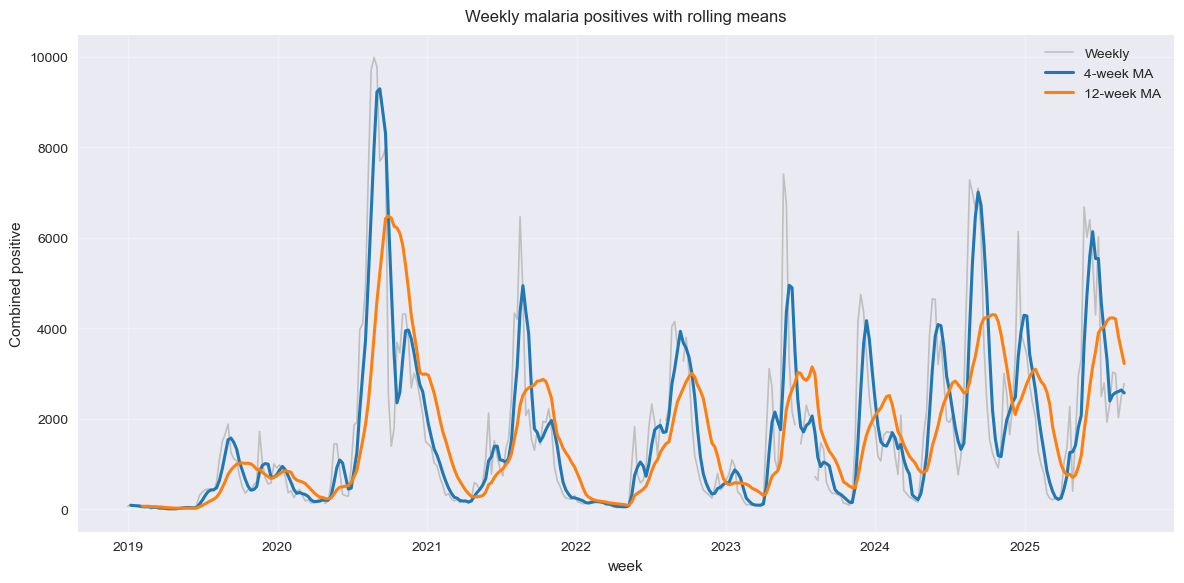

In [143]:
#check trends for malaria

# Ensure date column is datetime and sorted
data["week_start"] = pd.to_datetime(data["week_start"], errors="coerce")
data = data.dropna(subset=["week_start"]).sort_values("week_start")

# Clean numeric target
x = (
    data["Combined positive"].astype(str)
        .str.replace(",", "", regex=False)
        .str.replace(r"[^0-9.]", "", regex=True)
)
data["combined_positive"] = pd.to_numeric(x, errors="coerce")

# Rolling means
data["roll_4"]  = data["combined_positive"].rolling(window=4,  min_periods=2).mean()
data["roll_12"] = data["combined_positive"].rolling(window=12, min_periods=6).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data["week_start"], data["combined_positive"], color="0.75", lw=1.2, label="Weekly")
ax.plot(data["week_start"], data["roll_4"],  color="#1f77b4", lw=2.2, label="4-week MA")
ax.plot(data["week_start"], data["roll_12"], color="#ff7f0e", lw=2.2, label="12-week MA")
ax.set_title("Weekly malaria positives with rolling means", pad=10)
ax.set_xlabel("week")
ax.set_ylabel("Combined positive")
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.grid(True, alpha=0.3)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

### Summary of Malaria Trend Graph
Weekly malaria positive cases from 2019 to 2025, with rolling averages (4-week and 12-week) to smooth short-term and long-term trends.

Key observations:
* Seasonal peaks occur almost every year, indicating predictable malaria transmission cycles.
* Highest spikes appear around mid-2020 and mid-2023, suggesting outbreak periods.
* The 12-week rolling mean (orange) highlights a gradual upward trend in recent years, signaling a possible increase in baseline transmission.

Implications for programs:
* Early warning: Peaks align with seasonal patterns, so interventions (e.g., IRS, LLIN distribution) should be timed before these periods.
* Resource allocation: Sustained upward trend suggests the need for strengthened surveillance and preventive measures.

For the model: This trend data is crucial for **time-series**  features and **seasonality** adjustments in predictive modeling.

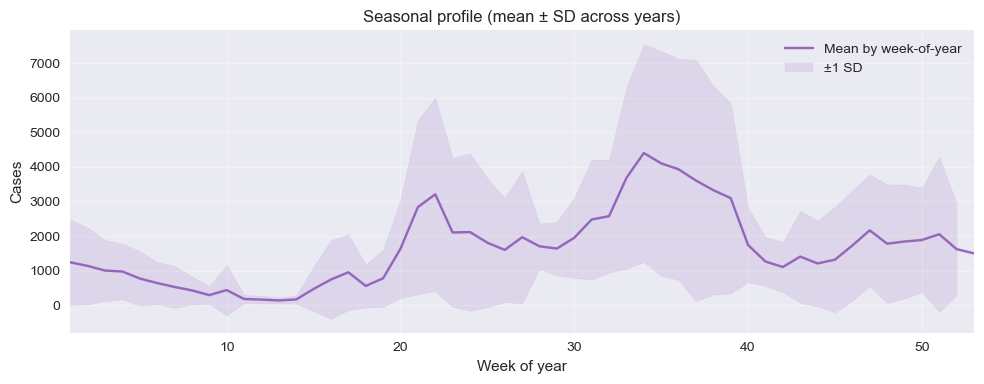

In [144]:
# Create a seasonality plot 

# Data preparation 
sdf = data.copy()
sdf["week_start"] = pd.to_datetime(sdf["week_start"], errors="coerce")
sdf = sdf.dropna(subset=["week_start"]).sort_values("week_start")

# Recheck that in the dataframe, the variable of iterest *'combined positive') exists as numeric
if "combined_positive" not in sdf.columns:
    x = (sdf["Combined positive"].astype(str)
            .str.replace(",", "", regex=False)
            .str.replace(r"[^0-9.]", "", regex=True))
    sdf["combined_positive"] = pd.to_numeric(x, errors="coerce")

value_col = "combined_positive"

# Rename the ISO week-of-year to week of the year (woy)
sdf["woy"] = sdf["week_start"].dt.isocalendar().week.astype(int)

# Aggregate by mean, median, std, count per week-of-year
seasonal = (
    sdf.groupby("woy")[value_col]
       .agg(mean="mean", median="median", std="std", count="count")
       .reset_index()
       .sort_values("woy")
)
# Plot the (mean ± 1 SD across years)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(seasonal["woy"], seasonal["mean"], color="tab:purple",
        label="Mean by week-of-year")

m = seasonal["mean"].to_numpy()
s = seasonal["std"].to_numpy()
ax.fill_between(seasonal["woy"], m - s, m + s,
                color="tab:purple", alpha=0.15, label="±1 SD")
ax.set_xlim(1, 53)
ax.set_xlabel("Week of year")
ax.set_ylabel("Cases")
ax.set_title("Seasonal profile (mean ± SD across years)")
ax.grid(True, alpha=0.3)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

### Seasonal Profile Graph
This shows the average malaria cases by week of the year across multiple years, with ±1 standard deviation to indicate variability.

Key observations:
* Two major seasonal peaks: around week 21 (May) and week 33 (August).
* The shaded band (±1 SD) shows high variability during peak weeks, meaning some years have much higher spikes than others.

Implications for programs:
* Targeted interventions (e.g., IRS, LLIN distribution, health messaging) should be prioritized before weeks 20 and 40.
* Variability suggests the need for flexible response plans during peak seasons.

For the model: This **confirms strong seasonality**, which should be incorporated as a key feature (e.g., week-of-year, lag variables).

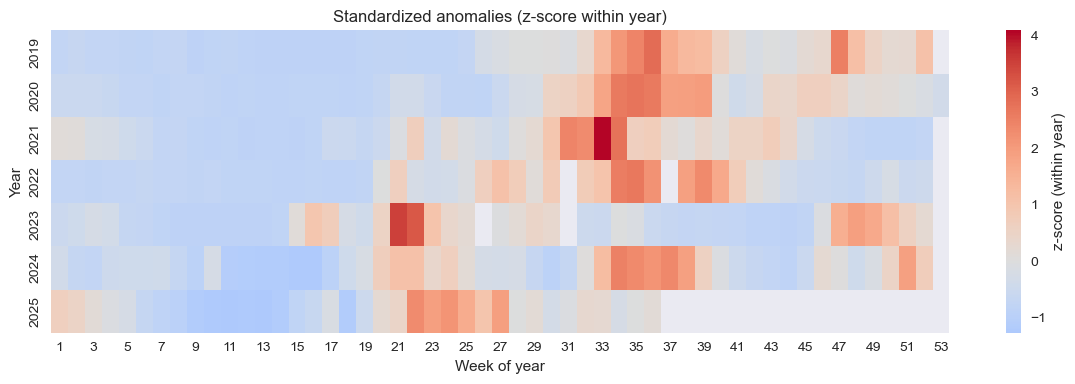

In [145]:
# Visualize off-season peaks in a standardised year using z-scores

# Create a copy of the desied columns 
dat = data.copy()

#Clean the copy to ensure the use ISO calendar so 'year' aligns with ISO week-of-year
iso = dat["week_start"].dt.isocalendar()
dat["year"] = iso.year.astype(int)      # ISO year
dat["woy"]  = iso.week.astype(int)      # 1..53

value_col = "combined_positive"

# Standardize within each (ISO) year
z = dat[["year", "woy", value_col]].copy()
z["cases_z"] = z.groupby("year")[value_col].transform(
    lambda s: (s - s.mean()) / (s.std(ddof=0) + 1e-9)
)

# Pivot to Year x Week-of-year
pivot = z.pivot_table(index="year", columns="woy", values="cases_z", aggfunc="mean")
pivot = pivot.reindex(sorted(pivot.columns), axis=1)  # ensure columns ordered 1..53

if sns is not None:
    plt.figure(figsize=(12, 4))
    ax = sns.heatmap(
        pivot, cmap="coolwarm", center=0,
        cbar_kws={"label": "z-score (within year)"}
    )
    ax.set_title("Standardized anomalies (z-score within year)")
    ax.set_xlabel("Week of year")
    ax.set_ylabel("Year")
    plt.tight_layout()
    plt.show()

### Summary of Anomaly Heatmap
This shows a standardised heatmap of anomalies (z-scores) of malaria cases by week of the year across 2018–2025.

Key observations:
* Red zones indicate weeks with much higher-than-normal cases, while blue zones indicate lower-than-normal.
* Consistent high anomalies appear around weeks 21 and 33, confirming strong seasonal peaks.
* Some years (e.g., 2021, 2023) show intense red clusters, aligning with outbreak years seen in the trend graph.

Implications for programs:
* Early detection: Monitoring anomalies can help trigger rapid response before outbreaks escalate.
* Predictive modeling: Anomaly patterns strengthen the case for including seasonality and lagged features in the model.

For decision-making: This heatmap is a visual early warning tool for identifying unusual malaria activity.

### 3.3 Correlation Analysis 

#### 3.3.1 Correlation with unlagged Weather Data

In [146]:
# Correlation and the effect of lags weather data

cols = [c for c in [value_col] + weather_cols if c in data.columns]
cmat = data[cols].corr(method='pearson')
cmat

,combined_positive,temp_c,rh_pct,rain_mm,wind10_kmh,soil_moisture_top_m3m3
combined_positive,1.000000,-0.097452,0.032343,-0.007098,-0.218869,0.024656
temp_c,-0.097452,1.000000,-0.900250,-0.696604,0.674034,-0.780325
rh_pct,0.032343,-0.900250,1.000000,0.741144,-0.659158,0.795378
rain_mm,-0.007098,-0.696604,0.741144,1.000000,-0.510401,0.758104
wind10_kmh,-0.218869,0.674034,-0.659158,-0.510401,1.000000,-0.620223
soil_moisture_top_m3m3,0.024656,-0.780325,0.795378,0.758104,-0.620223,1.000000


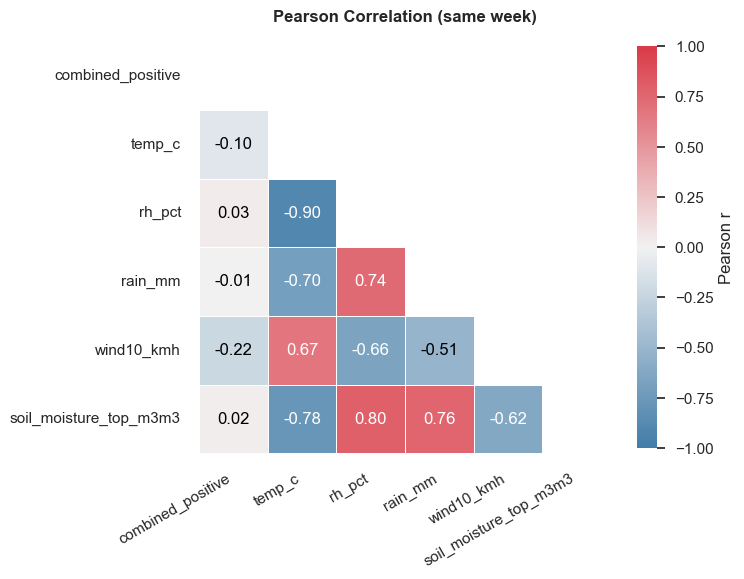

In [147]:
# cmat = the correlation DataFrame (square, indexed by column names), 
# Require to order variables by correlation with the target
target = "combined_positive"
order = (
    [target]
    + [c for c in cmat.columns if c != target]
)
cm = cmat.loc[order, order]

# Mask upper triangle for a cleaner look
mask = np.triu(np.ones_like(cm, dtype=bool))

plt.figure(figsize=(7.5, 6.5))
sns.set_theme(style="white")  # modern seaborn default

ax = sns.heatmap(
    cmat, mask=mask, annot=True, fmt=".2f", square=True,
    cmap=sns.diverging_palette(240, 10, as_cmap=True),  # nice diverging palette
    vmin=-1, vmax=1, center=0,
    linewidths=.6, linecolor="white",
    cbar_kws={"shrink": .8, "label": "Pearson r"}
)

# Improve text legibility on dark cells
for t in ax.texts:
    val = float(t.get_text())
    t.set_color("white" if abs(val) > 0.6 else "black")

ax.set_title("Pearson Correlation (same week)", pad=14, weight="bold")
ax.set_xlabel("")
ax.set_ylabel("")
plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Summary of Correlation Matrix without addition of lag effects**  
The correlation analysis shows that malaria cases (combined_positive) have only weak correlations with the weather variables in the same week, suggesting that malaria incidence is not strongly driven by any single climatic factor at the same time point. However, the predictors themselves are highly interrelated.   
* Temperature and relative humidity show a very strong negative correlation (-0.90), reflecting the natural relationship where higher temperatures reduce humidity.
* Similarly, rainfall is strongly correlated with both humidity (0.74) and soil moisture (0.76),
* Soil moisture is also positively related to humidity (0.80) and negatively related to temperature (-0.78).  
* Wind speed displays moderate relationships, being positively correlated with temperature (0.67) and negatively correlated with both rainfall (-0.51) and soil moisture (-0.62).

These patterns indicate substantial multicollinearity among the predictors, meaning they carry overlapping information. For modeling malaria cases, this suggests that using all variables together as they are may inflate variance, and that lagged effects of rainfall, humidity, and soil moisture might provide more predictive power than same-week correlations.

#### 3.3.2 Correlation with lagged Weather Data

In [148]:
max_lag = 12
lag_rows = []
for var in weather_cols:
    if var not in data.columns: 
        continue
    for k in range(0, max_lag+1):
        r = data[value_col].corr(data[var].shift(k))
        lag_rows.append({'variable': var, 'lag_weeks': k, 'corr': r})

lag_data = pd.DataFrame(lag_rows)
lag_data.pivot(index='lag_weeks', columns='variable', values='corr')

variable,rain_mm,rh_pct,soil_moisture_top_m3m3,temp_c,wind10_kmh
lag_weeks,,,,,
0,-0.007098,0.032343,0.024656,-0.097452,-0.218869
1,0.018572,0.097856,0.053274,-0.156024,-0.235587
2,0.089326,0.205106,0.138960,-0.265050,-0.292310
3,0.231823,0.376103,0.306140,-0.434096,-0.403808
4,0.386981,0.487528,0.410622,-0.538350,-0.476884
5,0.398155,0.485145,0.412543,-0.511134,-0.433917
6,0.388441,0.435893,0.363464,-0.438721,-0.361467
7,0.349326,0.366911,0.303102,-0.348926,-0.296207
8,0.287983,0.322054,0.278996,-0.288853,-0.269920


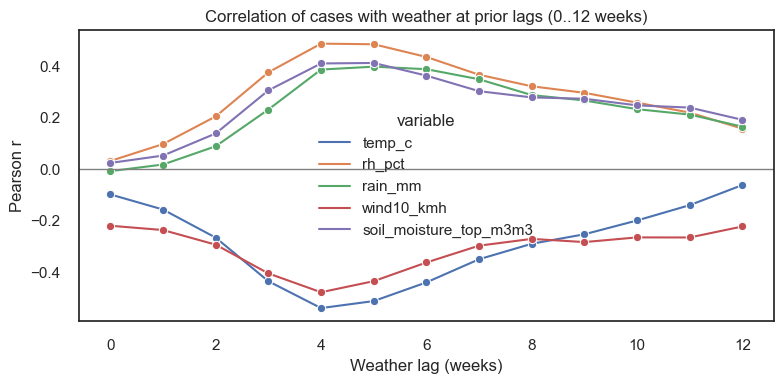

In [149]:
if sns is not None and len(lag_data):
    plt.figure(figsize=(8,4))
    sns.lineplot(data=lag_data, x='lag_weeks', y='corr', hue='variable', marker='o')
    plt.axhline(0, color='gray', lw=1)
    plt.title('Correlation of cases with weather at prior lags (0..12 weeks)')
    plt.xlabel('Weather lag (weeks)'); plt.ylabel('Pearson r')
    plt.tight_layout(); plt.show()

In [150]:
#- Compute correlations for lags 0 to 12

df = data.copy()
cases = df.set_index("week_start")["combined_positive"].astype(float)
full_idx = pd.date_range(cases.index.min(), cases.index.max(), freq="W-MON")
cases = cases.reindex(full_idx).ffill()

feat_cols = [c for c in ["temp_c","rh_pct","rain_mm","wind10_kmh","soil_moisture_top_m3m3"] if c in df.columns]
features = (df.set_index("week_start")[feat_cols]
              .apply(pd.to_numeric, errors="coerce")
              .reindex(full_idx)
              .ffill())

#Cross-correlation: feature[t-k] vs cases[t]
max_lag = 12
rows = []
for var in features.columns:
    for lag in range(0, max_lag + 1):
        r = cases.corr(features[var].shift(lag))  # feature leads by k weeks
        rows.append({"variable": var, "lag_weeks": lag, "pearson_r": r})

corr_df = pd.DataFrame(rows)
mat = (corr_df.pivot(index="variable", columns="lag_weeks", values="pearson_r")
               .sort_index())

#Extract best lag per feature (by |r|)
best = []
for var in mat.index:
    s = mat.loc[var]
    k = int(s.abs().idxmax())
    best.append({"variable": var, "best_lag_weeks": k, "best_r": float(s.loc[k])})

best_lags = pd.DataFrame(best).sort_values("variable").reset_index(drop=True)
#display(mat.round(3))
display(best_lags)

,variable,best_lag_weeks,best_r
0,rain_mm,5,0.393897
1,rh_pct,4,0.487538
2,soil_moisture_top_m3m3,4,0.409194
3,temp_c,4,-0.539473
4,wind10_kmh,4,-0.475243


The lagged correlation analysis reveals that malaria cases are more strongly associated with weather variables after a delay rather than in the same week. 
* Rainfall shows the highest positive correlation at a lag of five weeks (r = 0.39), suggesting that heavy rainfall influences malaria incidence about a month later, likely due to mosquito breeding cycles.
* Relative humidity and soil moisture both peak at a four-week lag, with correlations of 0.49 and 0.41 respectively, indicating that wetter conditions in the preceding month contribute to higher malaria risk.
* Temperature also shows its strongest relationship at a four-week lag but with a negative correlation (r = -0.54), implying that cooler periods a month earlier may create favorable conditions for malaria transmission.
* Wind speed peaks negatively at a four-week lag (r = -0.48), suggesting that lower wind speeds may favor mosquito survival and malaria spread.

Overall, these results highlight the importance of considering lagged weather effects, particularly rainfall, humidity, and temperature, when modeling and predicting malaria incidence.

### 3.3.3 Autocorrelation Function (ACF)

The **Autocorrelation Function (ACF)** shows how a time series relates to its past values across different lags. It helps detect patterns like trends or seasonality and is especially useful in identifying the order of Moving Average (MA) terms in ARIMA models. In practice, strong spikes at certain lags reveal how far back past values influence the present.

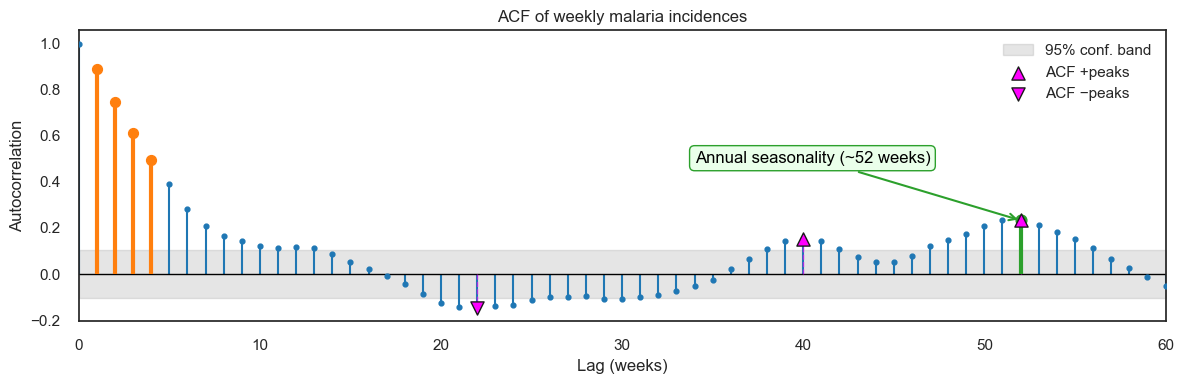

— Quick summary —
n_points: 349
conf_bound_95: 0.10491639460414909
top_short_lags: [1, 2, 3, 4]
seasonal_lag_52_significant: True
acf_at_lag_1: 0.8903950163689849
acf_at_lag_52: 0.2329898710122911
pos_peak_lags: [40, 52]
neg_peak_lags: [22]
dominant_abs_acf_lag: 1


In [151]:
# Since correlations even with lagged features is underwhelming, we need to check for other factors affecting malaria case counts 
# To achieve this, we plot the ACF for the weekly malaria cases

# Load & clean
df = data.copy()
raw = (df["Combined positive"].astype(str)
         .str.replace(",", "", regex=False)
         .str.replace(r"[^0-9.]", "", regex=True))
df["combined_positive"] = pd.to_numeric(raw, errors="coerce")

# Weekly grid & fill
series = df.set_index("week_start")["combined_positive"].astype(float)
full_idx = pd.date_range(series.index.min(), series.index.max(), freq="W-MON")
series = series.reindex(full_idx).ffill()

# ACF
nlags = 60
acf_vals, confint = acf(series, nlags=nlags, fft=True, alpha=0.05, missing="conservative")
N = int(series.notna().sum())
bound = 1.96 / np.sqrt(N)

lag_idx = np.arange(len(acf_vals))
sig_mask = np.abs(acf_vals) > bound
sig_lags = lag_idx[(sig_mask) & (lag_idx > 0)]

# Short-term highlights
top_short = [int(l) for l in sig_lags[(sig_lags >= 1) & (sig_lags <= 8)]]
top_short = sorted(top_short, key=lambda l: -abs(acf_vals[l]))[:4]

# Seasonal
seasonal_lag = 52 if nlags >= 52 else None
has_seasonal = seasonal_lag is not None and (np.abs(acf_vals[seasonal_lag]) > bound)

# Peak detection via scipy.signal
prominence = 0.03; min_distance = 2
pos_idx, _ = signal.find_peaks(acf_vals[1:], height=bound, prominence=prominence, distance=min_distance)
neg_idx, _ = signal.find_peaks(-acf_vals[1:], height=bound, prominence=prominence, distance=min_distance)
pos_lags = pos_idx + 1; neg_lags = neg_idx + 1
peak_lags_all = np.unique(np.r_[pos_lags, neg_lags])
if len(peak_lags_all) == 0:
    K = 5
    peak_lags_all = np.unique(np.argsort(-np.abs(acf_vals[1:]))[:K] + 1)

# Plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.vlines(lag_idx, [0], acf_vals, colors="tab:blue", lw=1.5)
ax.scatter(lag_idx, acf_vals, color="tab:blue", s=12, zorder=3)
ax.axhline(0, color="black", lw=1)
ax.fill_between(lag_idx, -bound, bound, color="tab:gray", alpha=0.2, label="95% conf. band")
ax.set_xlim(0, nlags); ax.set_xlabel("Lag (weeks)"); ax.set_ylabel("Autocorrelation")
ax.set_title("ACF of weekly malaria incidences")

for l in top_short:
    ax.vlines([l], [0], [acf_vals[l]], colors="tab:orange", lw=3, zorder=4)
    ax.scatter([l], [acf_vals[l]], color="tab:orange", s=50, zorder=5)

if has_seasonal:
    ax.vlines([seasonal_lag], [0], [acf_vals[seasonal_lag]], colors="tab:green", lw=3, zorder=4)
    ax.scatter([seasonal_lag], [acf_vals[seasonal_lag]], color="tab:green", s=60, zorder=6)
    ax.annotate("Annual seasonality (~52 weeks)",
                xy=(seasonal_lag, acf_vals[seasonal_lag]),
                xytext=(seasonal_lag-18, min(0.92, acf_vals[seasonal_lag]+0.25)),
                arrowprops=dict(arrowstyle="->", color="tab:green", lw=1.5),
                bbox=dict(boxstyle="round,pad=0.3", fc="#eaffea", ec="tab:green"),
                color="black")

if len(pos_lags) > 0:
    ax.scatter(pos_lags, acf_vals[pos_lags], marker="^", s=90, color="magenta", edgecolor="k", zorder=10, label="ACF +peaks")
if len(neg_lags) > 0:
    ax.scatter(neg_lags, acf_vals[neg_lags], marker="v", s=90, color="magenta", edgecolor="k", zorder=10, label="ACF −peaks")
if len(peak_lags_all) > 0:
    ax.vlines(peak_lags_all, 0, acf_vals[peak_lags_all], colors="magenta", linestyles="dashed", alpha=0.6, lw=1, zorder=3)

ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

# --- 5) Quick summary ---
summary = {
    "n_points": N,
    "conf_bound_95": float(bound) if np.isfinite(bound) else None,
    "top_short_lags": [int(x) for x in top_short],
    "seasonal_lag_52_significant": bool(has_seasonal),
    "acf_at_lag_1": float(acf_vals[1]) if len(acf_vals) > 1 else None,
    "acf_at_lag_52": float(acf_vals[52]) if len(acf_vals) > 52 else None,
    "pos_peak_lags": [int(x) for x in pos_lags],
    "neg_peak_lags": [int(x) for x in neg_lags],
    "dominant_abs_acf_lag": int(np.argmax(np.abs(acf_vals[1:])) + 1) if len(acf_vals) > 1 else None,
}
print("— Quick summary —")
for k, v in summary.items():
    print(f"{k}: {v}")

**ACF Output Interpretation**  
The ACF plot of weekly malaria incidences reveals the presence of a short-term dependence and long-term seasonality. 
* The strong correlations at the first few lags (1–4 weeks) indicate that malaria cases in a given week are heavily influenced by cases from the preceding weeks, reflecting short-term persistence in transmission patterns.
* The autocorrelation at lag 1 is significantly high (r ≈ 0.89), meaning the series is highly dependent on the immediate past.
* The significant peak at around 52 weeks highlights an annual seasonal cycle, suggesting that malaria incidence tends to repeat yearly, consistent with seasonal drivers such as rainfall and temperature cycles. The smaller positive peaks between lags 40 and 52 reinforce this seasonal effect.
* Negative autocorrelations around lag 22 suggest possible mid-year dips in malaria cases before rising again toward the seasonal peak.

#### 3.3.4 Partial Autocorrelation Function (PACF)

The **Partial Autocorrelation Function (PACF)** measures the direct relationship between a time series and its lagged values after accounting for the influence of shorter lags. Unlike the ACF, which shows both direct and indirect correlations, the PACF isolates the unique effect of each lag. This makes it especially useful in identifying the autoregressive order (p) in ARIMA models, since significant spikes in the PACF indicate which past values have a direct impact on the present.

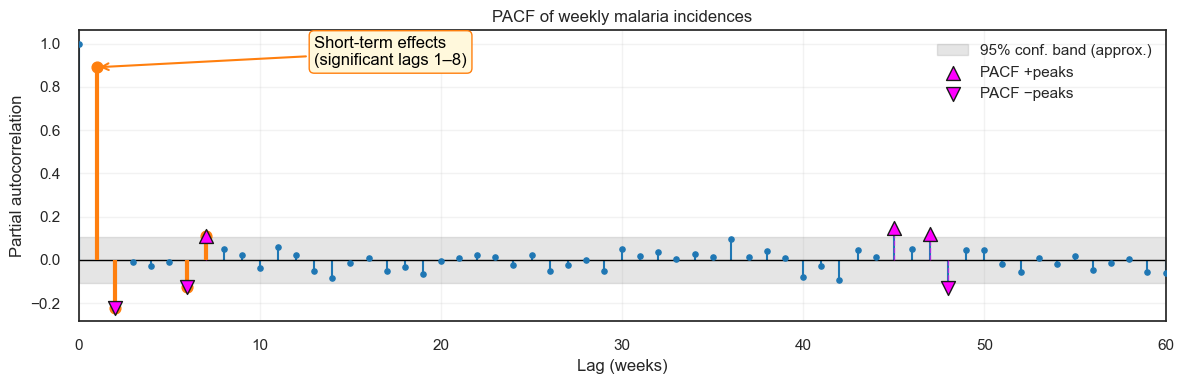

— summary —
used_method: ywmle
n_points: 349
conf_bound_95: 0.10491639460414909
nlags: 60
n_finite_pacf: 60
top_short_lags: [1, 2, 6, 7]
seasonal_lag_52_significant: False
pacf_at_lag_1: 0.8903950163689851
pacf_at_lag_52: -0.05423347428605589
pos_peak_lags: [7, 45, 47]
neg_peak_lags: [2, 6, 48]
fallback_used_for_peaks: False


In [152]:
#PACF plot for weekly malaria cases

# Load and prepare weekly series
df = data.copy()

# Clean target variable by ensuring it is numeric
raw = (
    df["Combined positive"].astype(str)
      .str.replace(",", "", regex=False)
      .str.replace(r"[^0-9.]", "", regex=True)
)
df["combined_positive"] = pd.to_numeric(raw, errors="coerce")

# Create regular weekly (Mondays) index and forward-fill short gaps
series = df.set_index("week_start")["combined_positive"].astype(float)
full_idx = pd.date_range(series.index.min(), series.index.max(), freq="W-MON")
series = series.reindex(full_idx).ffill()

# Perform sanity checks
N = int(series.notna().sum())
if N < 20:
    print(f"Warning: only {N} weekly points after cleaning; PACF may be unstable.")
if float(np.nanvar(series)) == 0.0:
    raise ValueError("The series is constant after cleaning; PACF signals cannot be computed.")

#PACF computation
nlags_requested = 60
nlags = min(nlags_requested, max(1, N // 2 - 2))  # safer cap given sample size

methods = ["ywmle", "ywadjusted", "ols", "ld"]  # try several in case of NaNs
pacf_vals = confint = None
used_method = None
for m in methods:
    try:
        pacf_vals, confint = pacf(series, nlags=nlags, method=m, alpha=0.05)
        if np.isfinite(pacf_vals[1:]).sum() > 1:
            used_method = m
            break
    except Exception:
        continue
if pacf_vals is None:
    raise RuntimeError("PACF failed with all methods. Check that the series is valid and long enough.")

#Build a simple visual 95% envelope (per‑lag confint still used for significance)
bound = 1.96 / np.sqrt(N) if N > 0 else np.nan

lag_idx = np.arange(len(pacf_vals))
finite_mask = np.isfinite(pacf_vals)

# Significance by (a) simple band or (b) confint excluding zero
sig_mask_simple = np.abs(pacf_vals) > bound
sig_mask_conf   = (confint[:, 0] > 0) | (confint[:, 1] < 0) if confint is not None else np.zeros_like(pacf_vals, bool)
sig_lags = lag_idx[(lag_idx > 0) & (sig_mask_simple | sig_mask_conf) & finite_mask]

# Short-term highlight (lags 1–8)
short_mask = (sig_lags >= 1) & (sig_lags <= 8)
top_short = [int(l) for l in sig_lags[short_mask]]
top_short = sorted(top_short, key=lambda l: -abs(pacf_vals[l]))[:4]

# Seasonal ~52 weeks (only if within computed range)
seasonal_lag = 52 if nlags >= 52 else None
has_seasonal = (
    seasonal_lag is not None
    and np.isfinite(pacf_vals[seasonal_lag])
    and (np.abs(pacf_vals[seasonal_lag]) > bound)
)

# Include peak detection feature with scipy.signal (positive & negative lobes)
prominence = 0.03   # decrease (e.g., 0.02) to see more peaks
min_distance = 2    # min separation (lags) between peaks

lags_1p = lag_idx[1:][np.isfinite(pacf_vals[1:])]
vals_1p = pacf_vals[1:][np.isfinite(pacf_vals[1:])]

pos_idx, _ = signal.find_peaks(vals_1p, height=bound, prominence=prominence, distance=min_distance)
neg_idx, _ = signal.find_peaks(-vals_1p, height=bound, prominence=prominence, distance=min_distance)
pos_lags = lags_1p[pos_idx] if len(pos_idx) else np.array([], dtype=int)
neg_lags = lags_1p[neg_idx] if len(neg_idx) else np.array([], dtype=int)
peak_lags_all = np.unique(np.r_[pos_lags, neg_lags])

# Fallback: if nothing passes threshold, mark top-K |PACF| finite lags
if len(peak_lags_all) == 0 and len(vals_1p) > 0:
    K = 5
    top_indices = np.argsort(-np.abs(vals_1p))[:K]
    peak_lags_all = np.unique(lags_1p[top_indices])
    fallback_used = True
else:
    fallback_used = False

# Plot the annotated PACF
fig, ax = plt.subplots(figsize=(12, 4))

# Stems + points for finite lags only
ax.vlines(lag_idx[finite_mask], 0, pacf_vals[finite_mask], colors="tab:blue", lw=1.5)
ax.scatter(lag_idx[finite_mask], pacf_vals[finite_mask], color="tab:blue", s=14, zorder=3)
ax.axhline(0, color="black", lw=1)

# Confidence band (simple visual)
ax.fill_between(lag_idx[finite_mask], -bound, bound, color="tab:gray", alpha=0.2, label="95% conf. band (approx.)")

ax.set_xlim(0, nlags)
ax.set_xlabel("Lag (weeks)")
ax.set_ylabel("Partial autocorrelation")
ax.set_title(f"PACF of weekly malaria incidences")

# Short-term effects
for l in top_short:
    ax.vlines([l], [0], [pacf_vals[l]], colors="tab:orange", lw=3, zorder=4)
    ax.scatter([l], [pacf_vals[l]], color="tab:orange", s=60, zorder=5)

if top_short:
    max_l = max(top_short)
    ax.annotate(
        "Short-term effects\n(significant lags 1–8)",
        xy=(top_short[0], pacf_vals[top_short[0]]),
        xytext=(min(nlags - 10, max(6, max_l + 6)),
                min(0.9, float(np.nanmax(np.abs(pacf_vals[1:9]))) + 0.2)),
        arrowprops=dict(arrowstyle="->", color="tab:orange", lw=1.5),
        bbox=dict(boxstyle="round,pad=0.3", fc="cornsilk", ec="tab:orange"),
        color="black"
    )

# Include Seasonal feature at 52nd week
if has_seasonal:
    ax.vlines([seasonal_lag], [0], [pacf_vals[seasonal_lag]], colors="tab:green", lw=3, zorder=4)
    ax.scatter([seasonal_lag], [pacf_vals[seasonal_lag]], color="tab:green", s=70, zorder=6)
    ax.annotate(
        "Annual component (~52 weeks)",
        xy=(seasonal_lag, pacf_vals[seasonal_lag]),
        xytext=(seasonal_lag - 18, min(0.92, pacf_vals[seasonal_lag] + 0.25)),
        arrowprops=dict(arrowstyle="->", color="tab:green", lw=1.5),
        bbox=dict(boxstyle="round,pad=0.3", fc="#eaffea", ec="tab:green"),
        color="black"
    )

# Peak markers
if len(pos_lags) > 0:
    ax.scatter(pos_lags, pacf_vals[pos_lags], marker="^", s=100, color="magenta", edgecolor="k", zorder=10, label="PACF +peaks")
if len(neg_lags) > 0:
    ax.scatter(neg_lags, pacf_vals[neg_lags], marker="v", s=100, color="magenta", edgecolor="k", zorder=10, label="PACF −peaks")
if len(peak_lags_all) > 0:
    ax.vlines(peak_lags_all, 0, pacf_vals[peak_lags_all], colors="magenta",
              linestyles="dashed", alpha=0.6, lw=1, zorder=3)

ax.legend(loc="upper right")
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

#Generate a summary
summary = {
    "used_method": used_method,
    "n_points": N,
    "conf_bound_95": float(bound) if np.isfinite(bound) else None,
    "nlags": int(nlags),
    "n_finite_pacf": int(np.isfinite(pacf_vals[1:]).sum()),
    "top_short_lags": [int(x) for x in top_short],
    "seasonal_lag_52_significant": bool(has_seasonal),
    "pacf_at_lag_1": float(pacf_vals[1]) if len(pacf_vals) > 1 and np.isfinite(pacf_vals[1]) else None,
    "pacf_at_lag_52": float(pacf_vals[52]) if len(pacf_vals) > 52 and np.isfinite(pacf_vals[52]) else None,
    "pos_peak_lags": [int(x) for x in np.array(pos_lags).tolist()],
    "neg_peak_lags": [int(x) for x in np.array(neg_lags).tolist()],
    "fallback_used_for_peaks": bool(fallback_used),
}
print("— summary —")
for k, v in summary.items():
    print(f"{k}: {v}")

**PACF Output Interpretation**  
* The PACF shows strong short-term autoregression, dominated by a very large spike at lag 1 (≈0.89) and smaller but still significant spikes within about lags 1–8, with the most notable at lags 2, 6, and 7. 
* Beyond these lags (1-8), the coefficients lie mostly inside the 95% band; the small peaks near 45–47 are weak, and there’s no significant seasonal spike at 52 weeks, indicating no direct seasonal AR effect. 
* This suggests a low-order AR component like ARIMA with p ≈ 1–2

#### 3.3.5 Seasonal Decomposition

Seasonal decomposition splits a time series into three interpretable components: a **trend** that captures long-term movement, a **seasonal** pattern that repeats at a fixed period, and a **residual** that contains irregular noise after removing trend and seasonality. We use an **additive** form when seasonal swings are roughly constant in size, $y_t = T_t + S_t + R_t$, and a **multiplicative** form when seasonal effects scale with the level, $y_t = T_t \times S_t \times R_t$ (or *log-transform* and then use the *additive form*). 

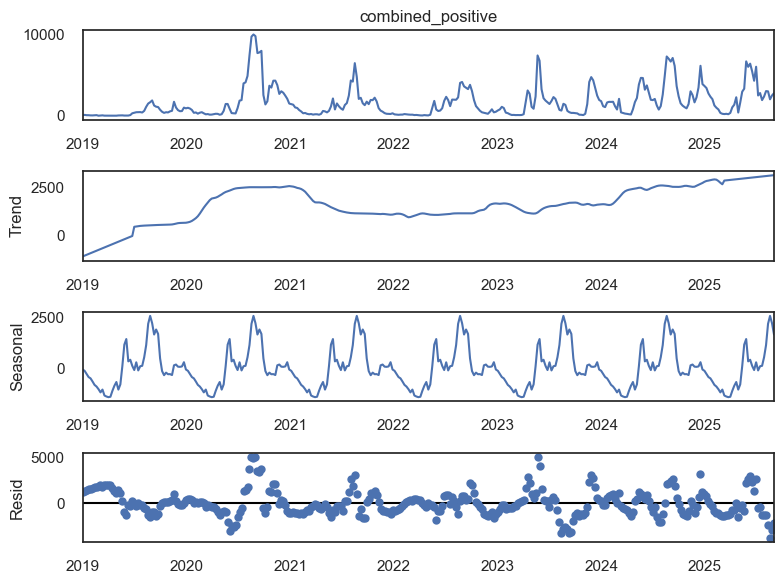

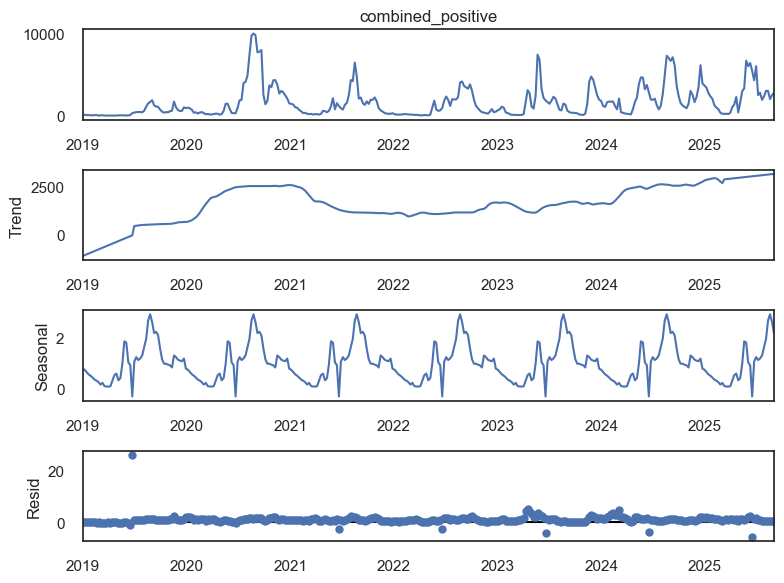

In [153]:
# Prep from your DataFrame `data` 
ts = data.copy()
ts["week_start"] = pd.to_datetime(ts["week_start"], errors="coerce")
ts = ts.dropna(subset=["week_start"]).sort_values("week_start")

# Ensure numeric target: create 'combined_positive' if missing
if "combined_positive" not in ts.columns:
    x = (ts["Combined positive"].astype(str)
            .str.replace(",", "", regex=False)
            .str.replace(r"[^0-9.]", "", regex=True))
    ts["combined_positive"] = pd.to_numeric(x, errors="coerce")

# Build continuous weekly (Mon) index and fill gaps for decomposition
y = ts.set_index("week_start")["combined_positive"].astype(float)
full_idx = pd.date_range(y.index.min(), y.index.max(), freq="W-MON")
y = y.reindex(full_idx).interpolate(limit_direction="both")

# Log-transform (optional) — useful if seasonal amplitude scales with level
y_log = np.log1p(y)  # log(1 + y) handles zeros safely

# ADDITIVE decomposition
res_add = seasonal_decompose(y, model="additive", period=52, extrapolate_trend="freq")
fig = res_add.plot()
fig.set_size_inches(8, 6)
plt.tight_layout()
# plt.savefig("seasonal_decomp_additive.png", dpi=160, bbox_inches="tight")
plt.show()

# --- MULTIPLICATIVE decomposition ---
# Works best when seasonal amplitude scales with the level.
# (Equivalently, you can apply additive decomposition to y_log.)
res_mul = seasonal_decompose(y, model="multiplicative", period=52, extrapolate_trend="freq")
fig = res_mul.plot()
fig.set_size_inches(8, 6)
plt.tight_layout()
# plt.savefig("seasonal_decomp_multiplicative.png", dpi=160, bbox_inches="tight")
plt.show()

**Additive Model**
* The additive decomposition shows that weekly malaria positives combine a slowly varying trend, a stable seasonal cycle, and irregular residual shocks.
* The trend rises from 2019 into early-2021, eases through 2022, then resumes a steady climb from 2023 into 2025, indicating a long-run upward level.
* The seasonal component displays a strong, repeating annual pattern (roughly 52-week cycle) with a fairly constant amplitude, supporting the additive assumption that seasonality is independent of the level.
* The residuals are centered near zero but contain intermittent large positive and negative spikes—especially around 2020–2021 and 2023—suggesting episodic shocks or reporting anomalies that are not explained by trend or seasonality.
* Overall, the decomposition captures most systematic structure (trend + seasonality), leaving short-lived deviations in the residuals.

**Multiplicative Model**
* The multiplicative decomposition indicates that weekly malaria positives are well described by a level that changes slowly over time, a seasonal index that scales the level, and relatively small irregular noise.
* The trend rises sharply through 2020–early-2021, eases during 2021–2022, and then climbs again from 2023 onward, pointing to a long-run upward shift in the baseline.
* The seasonal component shows a stable ~52-week cycle whose magnitude depends on the level: seasonal indices range roughly from a little below 1 in the off-season to around 2–3 at the peak, meaning incidence can be two to three times the baseline during peak weeks.
* The residuals are mostly near zero with a few isolated spikes, suggesting that trend and multiplicative seasonality explain most of the variation and that remaining shocks are short-lived.

For Modeling, a log transform or seasonal ARIMA with multiplicative seasonality (SARIMA) is appropriate, and deseasonalizing by dividing by the seasonal index will yield a smoother series for forecasting.

In [154]:
# Residual variance comparison
var_add = np.var(res_add.resid.dropna())
var_mul = np.var(res_mul.resid.dropna())
print("Residual variance (additive):      ", var_add)
print("Residual variance (multiplicative):", var_mul)

# Whiteness: Ljung-Box (lower p-value -> more autocorrelation; higher p -> closer to white noise)
lb_add = acorr_ljungbox(res_add.resid.dropna(), lags=[8, 16], return_df=True)
lb_mul = acorr_ljungbox(res_mul.resid.dropna(), lags=[8, 16], return_df=True)
print("\nLjung-Box additive:\n", lb_add)
print("\nLjung-Box multiplicative:\n", lb_mul)

Residual variance (additive):       1914749.9561138102
Residual variance (multiplicative): 2.834329216844962

Ljung-Box additive:
        lb_stat      lb_pvalue
8   527.361568  9.438983e-109
16  604.954644  2.033862e-118

Ljung-Box multiplicative:
       lb_stat  lb_pvalue
8    9.998336   0.265143
16  13.670288   0.623262


**Comparison of Additive and Multiplicative Models**
* The residual variance diagnostics imply that the multiplicative model is superior compared to the additive model.  
* The residual variance of multiplicative model (≈2.83) is smaller than the additive model’s (≈1.91×10⁶)
* The Ljung–Box test fails to reject white noise at lags 8 and 16 (p = 0.27 and 0.62), indicating little remaining autocorrelation.
* In contrast, the additive residuals show extremely small p-values (≈9e-109 and ≈2e-118), meaning strong leftover autocorrelation and a poor fit.

The multiplicative (or log-scale) decomposition captures the structure much better and leaves near-white-noise residuals—use it as the basis for forecasting

## 4.0 Modeling and Evaluation

### 4.1 Load & clean the dataset

In [155]:
# Function to load and clean the dataset
def load_and_clean_data():
    # Load the dataset from Data folder
    data = pd.read_csv('Data/final_dataset.csv')
    
    # Clean 'Combined positive' column
    data['Combined positive'] = data['Combined positive'].replace('#VALUE!', np.nan)
    data['Combined positive'] = data['Combined positive'].str.replace(',', '').astype(float)
    data['Combined positive'] = data['Combined positive'].fillna(data['Combined positive'].median())
    
    # Clip outliers in Combined positive (1st and 99th percentiles)
    q_low = data['Combined positive'].quantile(0.01)
    q_high = data['Combined positive'].quantile(0.99)
    data['Combined positive'] = data['Combined positive'].clip(q_low, q_high)
    
    # Convert week_start to datetime
    data['week_start'] = pd.to_datetime(data['week_start'])
    
    return data

In [156]:
data.tail()

,week_start,Combined positive,temp_c,rh_pct,rain_mm,wind10_kmh,soil_moisture_top_m3m3,combined_positive,roll_4,roll_12
344,2025-08-04,"3,030",25.939286,66.797619,64.5,5.732143,0.175923,3030.0,2528.00,4232.666667
345,2025-08-11,"2,999",26.997619,56.714286,15.8,7.589286,0.091679,2999.0,2579.75,4205.916667
346,2025-08-18,"2,024",24.664286,72.523810,76.0,7.420833,0.190036,2024.0,2604.25,3817.666667
347,2025-08-25,"2,494",27.955357,52.958333,3.3,6.576786,0.034940,2494.0,2636.75,3524.500000
348,2025-09-01,"2,776",28.294048,51.833333,5.4,7.726786,0.086607,2776.0,2573.25,3222.500000


### 4.2 Add Seasonality, Lagged, Rolling, and Interaction Features

In [157]:
# Function to add seasonality, lagged, rolling, and interaction features
def add_features(data):
    # Seasonality features
    data['month'] = data['week_start'].dt.month
    data['week_of_year'] = data['week_start'].dt.isocalendar().week.astype(float)  # Cast to float64
    data['sin_month'] = np.sin(2 * np.pi * data['month'] / 12)
    data['cos_month'] = np.cos(2 * np.pi * data['month'] / 12)
    data['sin_week'] = np.sin(2 * np.pi * data['week_of_year'] / 52)
    data['cos_week'] = np.cos(2 * np.pi * data['week_of_year'] / 52)
    
    # Lagged features
    lag_features = {
        'temp_c': [4],
        'rh_pct': [4, 5],
        'rain_mm': [5, 6],
        'soil_moisture_top_m3m3': [4, 5],
        'wind10_kmh': [4],
        'Combined positive': list(range(1, 9))
    }
    for feature, lags in lag_features.items():
        for lag in lags:
            data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
    
    # Rolling features for Combined positive
    for window in [4, 8]:
        data[f'Combined_positive_roll_mean_{window}'] = data['Combined positive'].shift(1).rolling(window=window).mean()
        data[f'Combined_positive_roll_std_{window}'] = data['Combined positive'].shift(1).rolling(window=window).std()
    
    # Interaction terms
    data['rain_soil_interaction'] = data['rain_mm'] * data['soil_moisture_top_m3m3']
    data['temp_rh_interaction'] = data['temp_c'] * data['rh_pct']
    
    # Drop rows with NaN values
    data = data.dropna().reset_index(drop=True)
    return data

### 4.3 Calculate MASE Metric

In [158]:
# Function to calculate MASE for regression
def calculate_mase(y_true, y_pred, y_train):
    naive_forecast = y_train.shift(1).dropna()
    naive_true = y_train[1:]
    mae_naive = mean_absolute_error(naive_true, naive_forecast)
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive if mae_naive != 0 else np.inf

### 4.4 Split Dataset by Weeks

In [159]:
# Function to split dataset by Weeks
def split_dataset_by_years(data):
    # Define splits
    train_data = data[data['week_start'] <= '2023-12-31'].copy() ## 261 weeks - 75%
    val_data = data[(data['week_start'] >= '2024-01-01') & (data['week_start'] <= '2024-12-31')].copy() ## 53 weeks - 15%
    test_data = data[data['week_start'] >= '2025-01-01'].copy() ## 35 weeks - 10%
    
    # Check for empty splits
    if train_data.empty:
        print("Warning: Training set is empty.")
    if val_data.empty:
        print("Warning: Validation set is empty.")
    if test_data.empty:
        print("Warning: Test set is empty.")
    
    return train_data, val_data, test_data

### 4.5 Prepare Splits for Modeling

In [160]:
# Function to prepare features and targets
def prepare_splits(data):
    # Split by years
    train_data, val_data, test_data = split_dataset_by_years(data)
    
    # Features (exclude non-feature columns)
    features = [col for col in data.columns if col not in ['week_start', 'Combined positive', 'ratio', 'class_target']]
    
    # Regression target: Combined positive (not log1p, as specified)
    train_data['reg_target'] = train_data['Combined positive']
    val_data['reg_target'] = val_data['Combined positive']
    test_data['reg_target'] = test_data['Combined positive']
    
    # Classification target: w2/w1 >= 1.5
    data['ratio'] = data['Combined positive'].shift(-1) / data['Combined positive']
    data['class_target'] = (data['ratio'] >= 1.5).astype(int)
    train_data['class_target'] = data.loc[train_data.index, 'class_target']
    val_data['class_target'] = data.loc[val_data.index, 'class_target']
    test_data['class_target'] = data.loc[test_data.index, 'class_target']
    
    # Split features and targets
    X_train = train_data[features].astype(float)
    y_train_reg = train_data['reg_target']
    y_train_class = train_data['class_target']
    X_val = val_data[features].astype(float)
    y_val_reg = val_data['reg_target']
    y_val_class = val_data['class_target']
    X_test = test_data[features].astype(float)
    y_test_reg = test_data['reg_target']
    y_test_class = test_data['class_target']
    y_train_orig = train_data['Combined positive']
    y_val_orig = val_data['Combined positive']
    y_test_orig = test_data['Combined positive']
    
    return (X_train, y_train_reg, y_train_class, y_train_orig,
            X_val, y_val_reg, y_val_class, y_val_orig,
            X_test, y_test_reg, y_test_class, y_test_orig)

### 4.6 Hyperparameter Tuning Function

In [161]:
# Function to tune models using GridSearchCV
def tune_model(model, X_train, y_train, param_grid):
    tscv = TimeSeriesSplit(n_splits=5)
    search = GridSearchCV(model, param_grid, cv=tscv, 
                          scoring='neg_mean_absolute_error' if 'Regressor' in str(model.__class__) else 'roc_auc', 
                          n_jobs=-1)
    search.fit(X_train, y_train)
    return search.best_estimator_

### 4.7 Plotting Functions

In [162]:
# Function to plot feature importance
def plot_feature_importance(model, X, model_name):
    if hasattr(model, 'feature_importances_'):
        importance = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values(by='importance', ascending=False)
    else:  # For HGB, which may not have feature_importances_
        importance = pd.DataFrame({
            'feature': X.columns,
            'importance': np.ones(X.shape[1])  # Placeholder
        })
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance)
    plt.title(f'Feature Importance - {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Function to plot predicted vs. actual for regression
def plot_pred_vs_actual(y_true, y_pred, set_name, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Combined Positive')
    plt.ylabel('Predicted Combined Positive')
    plt.title(f'Predicted vs. Actual - {model_name} ({set_name})')
    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix for classification
def plot_confusion_matrix(y_true, y_pred, set_name, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name} ({set_name})')
    plt.tight_layout()
    plt.show()

# Function to plot time-series of actual vs. predicted for regression
def plot_time_series(data, y_true, y_pred, set_name, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data['week_start'], y_true, label='Actual Combined Positive', marker='o')
    plt.plot(data['week_start'], y_pred, label='Predicted Combined Positive', marker='x')
    plt.xlabel('Week Start')
    plt.ylabel('Combined Positive')
    plt.title(f'Time-Series: Actual vs. Predicted - {model_name} ({set_name})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 4.8 Main Pipeline¶

In [ ]:
import joblib


def main():
    #Load & feature engineering
    data = load_and_clean_data()
    data = add_features(data)

    # Split Train, test and validation data
    (X_train, y_train_reg, y_train_class, y_train_orig,
     X_val,   y_val_reg,   y_val_class,   y_val_orig,
     X_test,  y_test_reg,  y_test_class,  y_test_orig) = prepare_splits(data)

    # 3) Class balance + SMOTE (classification only)
    print("Class distribution before SMOTE:\n", y_train_class.value_counts())
    smote = SMOTE(random_state=42)
    try:
        X_train_class, y_train_class = smote.fit_resample(X_train, y_train_class)
        print("Class distribution after SMOTE:\n", pd.Series(y_train_class).value_counts())
    except Exception as e:
        print(f"SMOTE failed: {e}")
        X_train_class, y_train_class = X_train, y_train_class

    # 4) Apply RANDOM FOREST
    # Regression
    rf_reg = RandomForestRegressor(random_state=42)
    rf_reg_grid = {
        "n_estimators": [100, 200],
        "max_depth": [5, 10, None],
        "min_samples_split": [2, 5],
    }
    rf_reg_best = tune_model(rf_reg, X_train, y_train_reg, rf_reg_grid)

    # Validation & test predictions
    y_pred_reg_val  = rf_reg_best.predict(X_val)
    y_pred_reg_test = rf_reg_best.predict(X_test)

    # Compute regression metrics
    mase_val  = calculate_mase(y_val_orig,  y_pred_reg_val,  y_train_orig)
    r2_val    = r2_score(y_val_orig,  y_pred_reg_val)
    mase_test = calculate_mase(y_test_orig, y_pred_reg_test, y_val_orig)
    r2_test   = r2_score(y_test_orig, y_pred_reg_test)
    print(f"[RF Regressor] Validation:  MASE={mase_val:.2f}, R²={r2_val:.3f}")
    print(f"[RF Regressor] Test:        MASE={mase_test:.2f}, R²={r2_test:.3f}")

    # Create Regression Plots
    plot_feature_importance(rf_reg_best, X_train, "RandomForest Regressor")
    plot_pred_vs_actual(y_val_orig,  y_pred_reg_val,  "Validation Set", "RandomForest")
    plot_pred_vs_actual(y_test_orig, y_pred_reg_test, "Test Set",       "RandomForest")

    # Perform Classification
    rf_clf = RandomForestClassifier(random_state=42)
    rf_clf_grid = {
        "n_estimators": [100, 200],
        "max_depth": [5, 10, None],
        "min_samples_split": [2, 5],
        "class_weight": ["balanced", None],
    }
    rf_clf_best = tune_model(rf_clf, X_train_class, y_train_class, rf_clf_grid)


    joblib.dump(rf_clf_best, "malaria_rf_classifier.pkl")
    joblib.dump(rf_reg_best, "malaria_rf_regressor.pkl")

    # Probabilities
    y_proba_val  = rf_clf_best.predict_proba(X_val)[:, 1]
    y_proba_test = rf_clf_best.predict_proba(X_test)[:, 1]

    # Establish threshold tuning on validation (maximize F1)
    thresholds = np.arange(0.3, 0.81, 0.05)
    best_thr, best_f1 = 0.5, -1
    for thr in thresholds:
        y_hat = (y_proba_val >= thr).astype(int)
        p = precision_score(y_val_class, y_hat)
        r = recall_score(y_val_class, y_hat)
        f1 = 2 * p * r / (p + r + 1e-10)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr

    # Final preds
    y_pred_val  = (y_proba_val  >= best_thr).astype(int)
    y_pred_test = (y_proba_test >= best_thr).astype(int)

    # Compute Classification Metrics
    precision_val = precision_score(y_val_class,  y_pred_val)
    recall_val    = recall_score(y_val_class,     y_pred_val)
    roc_auc_val   = roc_auc_score(y_val_class,    y_proba_val)
    precision_tst = precision_score(y_test_class, y_pred_test)
    recall_tst    = recall_score(y_test_class,    y_pred_test)
    roc_auc_tst   = roc_auc_score(y_test_class,   y_proba_test)

    print(f"[RF Classifier] Validation: Precision={precision_val:.2f}, Recall={recall_val:.2f}, "
          f"ROC-AUC={roc_auc_val:.3f}, BestThr={best_thr:.2f}")
    print(f"[RF Classifier] Test:       Precision={precision_tst:.2f}, Recall={recall_tst:.2f}, "
          f"ROC-AUC={roc_auc_tst:.3f}")

    # Plots (classification)
    plot_feature_importance(rf_clf_best, X_train, "RandomForest Classifier")
    plot_confusion_matrix(y_val_class,  y_pred_val,  "Validation Set", "RandomForest")
    plot_confusion_matrix(y_test_class, y_pred_test, "Test Set",       "RandomForest")

    # # Time-series plot for RF regressor
    # plot_time_series(val_data,  y_val_orig,  y_pred_reg_val,  "Validation Set", "RandomForest")
    # plot_time_series(test_data, y_test_orig, y_pred_reg_test, "Test Set",       "RandomForest")


if __name__ == "__main__":
    main()



In [164]:
import sklearn
print(sklearn.__version__)


1.2.1
